In [1]:
import dask.dataframe as dd
import pickle
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from PIL import Image
from io import BytesIO
from sklearn.preprocessing import LabelEncoder

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model info
with open('advanced_ml_project_model_vF.pkl', 'rb') as f:
    model_info = pickle.load(f)

num_classes = model_info['num_classes']

# Rebuild architecture
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(model_info['state_dict'])

model = model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
# Same image preprocessing used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load the encoder
with open('label_encoder_vF.pkl', 'rb') as f:
    le = pickle.load(f)

# Inference function
def predict_from_bytes(img_bytes):
    model.eval()
    image = Image.open(BytesIO(img_bytes)).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        class_index = predicted.item()
        return le.inverse_transform([class_index])[0]  # Return class label

#DataSet

In [3]:
# Read the dataset from Hugging Face using Dask
df = dd.read_parquet(
    "hf://datasets/raghavendrad60/vqa_plant-disease-classification-merged-dataset/data/train-*.parquet",
    columns=['class', 'image']
)

# Plants to keep
patterns = ['Tomato', 'Chili', 'Cucumber', 'Strawberry', 'Pepper']
desired_plants = [p.lower() for p in patterns]

# Filter function to include only desired plants
def filter_partition(df):
    df['class'] = df['class'].astype(str).str.strip().str.lower()
    df['plant'] = df['class'].str.extract(r'^([^_]+)')
    return df[df['plant'].isin(desired_plants)]

df = df.map_partitions(filter_partition).persist()

# Function to sample a small number of rows from a partition
def sample_partition(partition, n_per_partition=400):
    return partition.sample(n=min(len(partition), n_per_partition), random_state=42)

# Sample a limited number of rows from each partition
sampled = df.map_partitions(sample_partition, n_per_partition=400)

# Collect the sampled data into memory, then take a final random sample of 50000
sampled_df = sampled.compute()
final_sample = sampled_df.sample(n=min(50000, len(sampled_df)), random_state=42)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


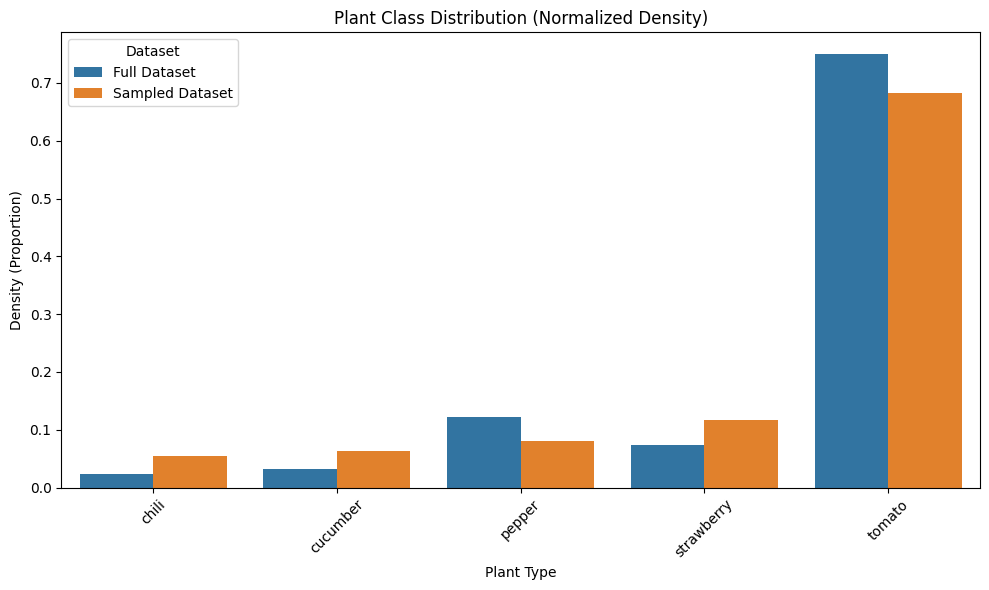

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Add 'plant' column to sampled_df
sampled_df['plant'] = sampled_df['class'].str.extract(r'^([^_]+)').iloc[:, 0]

# Compute full (filtered) dataset
full_df = df.compute()
full_df['plant'] = full_df['class'].str.extract(r'^([^_]+)').iloc[:, 0]

# Create normalized frequency (density) data
full_density = full_df['plant'].value_counts(normalize=True)
sampled_density = sampled_df['plant'].value_counts(normalize=True)

# Convert to DataFrame for plotting
density_df = pd.DataFrame({
    'Full Dataset': full_density,
    'Sampled Dataset': sampled_density
}).fillna(0).sort_index()

# Reset index and rename
density_df = density_df.reset_index().rename(columns={'index': 'plant'})

# Melt for seaborn
density_melted = density_df.melt(id_vars='plant', var_name='Dataset', value_name='Density')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=density_melted, x='plant', y='Density', hue='Dataset')
plt.title("Plant Class Distribution (Normalized Density)")
plt.ylabel("Density (Proportion)")
plt.xlabel("Plant Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# Count rows per class sample
class_counts = final_sample['class'].value_counts()
print(class_counts)

class
tomato__yellow_leaf_curl_virus                    749
tomato__target_spot                               729
tomato__late_blight                               571
tomato__septoria_leaf_spot                        469
tomato__leaf_mold                                 413
tomato__spider_mites_(two_spotted_spider_mite)    400
strawberry___leaf_scorch                          400
strawberry__healthy                               387
tomato__healthy                                   381
pepper_bell__healthy                              342
cucumber__healthy                                 341
tomato__bacterial_spot                            331
tomato__mosaic_virus                              290
tomato__early_blight                              255
pepper_bell__bacterial_spot                       203
chili__yellowish                                  100
chili__leaf curl                                  100
cucumber__diseased                                 90
chili__healthy        

In [6]:
# Count rows per class full dataset
class_counts = full_df['class'].value_counts()
print(class_counts)

class
tomato__yellow_leaf_curl_virus                    3214
tomato__bacterial_spot                            2136
tomato__late_blight                               1919
tomato__septoria_leaf_spot                        1782
tomato__spider_mites_(two_spotted_spider_mite)    1676
tomato__healthy                                   1598
pepper_bell__healthy                              1539
tomato__target_spot                               1404
strawberry___leaf_scorch                          1109
pepper_bell__bacterial_spot                       1067
tomato__early_blight                              1009
tomato__leaf_mold                                  957
strawberry__healthy                                456
tomato__mosaic_virus                               382
cucumber__diseased                                 350
cucumber__healthy                                  341
chili__whitefly                                    100
chili__healthy                                     100
chil

#Convusion Matrix

In [7]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions and collect true labels
true_labels = []
predicted_labels = []

for idx, row in tqdm(final_sample.iterrows(), total=len(final_sample), desc="Generating predictions"):
    img_bytes = row['image']['bytes']
    true_label = row['class'].strip().lower()
    try:
        predicted_label = predict_from_bytes(img_bytes)
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)
    except Exception as e:
        print(f"Error processing row {idx}: {e}")

Generating predictions: 100%|██████████| 6721/6721 [13:41<00:00,  8.18it/s]


In [8]:
from sklearn.metrics import confusion_matrix

# Convert to binary labels
def to_binary(label):
    return 'healthy' if 'healthy' in label else 'diseased'

# Apply conversion
true_labels_binary = [to_binary(label) for label in true_labels]
predicted_labels_binary = [to_binary(label) for label in predicted_labels]

# Generate confusion matrix
cm = confusion_matrix(true_labels_binary, predicted_labels_binary, labels=['diseased', 'healthy'])

# Unpack into TP, FP, FN, TN
tp = cm[0, 0]  # Diseased predicted as diseased
fp = cm[1, 0]  # Healthy predicted as diseased
fn = cm[0, 1]  # Diseased predicted as healthy
tn = cm[1, 1]  # Healthy predicted as healthy

print(f"True Positive (TP): {tp}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"True Negative (TN): {tn}")

True Positive (TP): 4947
False Positive (FP): 19
False Negative (FN): 252
True Negative (TN): 1503


# Metrics

In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Compute basic metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')  # or 'macro', 'micro'

# Print results
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Optionally: detailed per-class report
print("\nClassification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=le.classes_))

Accuracy:  0.8985
Precision: 0.9139
Recall:    0.8985
F1 Score:  0.8955

Classification Report:

                                                precision    recall  f1-score   support

                                chili__healthy       0.50      0.90      0.64        71
                              chili__leaf curl       0.53      0.87      0.66       100
                              chili__leaf spot       0.93      0.39      0.55        71
                               chili__whitefly       0.85      0.39      0.54        28
                              chili__yellowish       1.00      0.24      0.39       100
                            cucumber__diseased       0.92      0.86      0.89        90
                             cucumber__healthy       0.96      0.97      0.97       341
                   pepper_bell__bacterial_spot       0.90      0.61      0.73       203
                          pepper_bell__healthy       0.70      0.99      0.82       342
                      

#Prediction

In [11]:
# Picture input (from file or database)
with open("/content/Tomato_Leaf_Mold_Test3", "rb") as f:
    img_bytes = f.read()

predicted_class = predict_from_bytes(img_bytes)
print("Predicted class:", predicted_class)

Predicted class: tomato__leaf_mold
